# Wavelength Selection Validation Pipeline - Complete

This notebook provides a comprehensive validation pipeline for wavelength selection with:
- Fixed wavelength extraction (no more TypeError!)
- Multiple meaningful configurations
- Results saved to DataFrame and Excel
- Clustering visualizations saved for each configuration

## Pipeline Steps:
1. Load data and ground truth
2. Run baseline (full data) clustering
3. Test multiple wavelength selection configurations
4. Compare all results
5. Save comprehensive analysis

## 1. Setup and Imports

In [14]:
def select_informative_wavelengths_fixed(data_path, mask_path, sample_name, config_params, verbose=True):
    # Create model directory
    model_dir = base_dir / \"results\" / f\"{sample_name}_wavelength_selection\" / \"model\"
    model_dir.mkdir(parents=True, exist_ok=True)
    model_path = model_dir / \"autoencoder_model.pth\"
    
    # Create configuration
    config = AnalysisConfig(
        sample_name=sample_name,
        data_path=str(data_path),
        mask_path=str(mask_path),
        model_path=str(model_path),
        dimension_selection_method=config_params.get('dimension_selection_method', 'activation'),
        perturbation_method=config_params.get('perturbation_method', 'percentile'),
        perturbation_magnitudes=config_params.get('perturbation_magnitudes', [10, 20, 30]),
        n_important_dimensions=config_params.get('n_important_dimensions', 15),
        n_bands_to_select=config_params.get('n_bands_to_select', 30),
        normalization_method=config_params.get('normalization_method', 'variance'),
        output_dir=str(model_dir.parent / \"output\"),
        save_tiff_layers=False,
        save_visualizations=False,
        n_baseline_patches=10
    )
    
    if verbose:
        print(f\"\\nRunning wavelength selection: {config_params.get('name', 'unnamed')}\")
    
    # Initialize analyzer
    analyzer = WavelengthAnalyzer(config)
    
    # Load data and model
    analyzer.load_data_and_model()
    
    # Run wavelength selection analysis
    results = analyzer.run_complete_analysis()
    
    if results is None or 'selected_bands' not in results:
        raise ValueError(\"Wavelength selection failed to return results\")
    
    # FIXED: Extract excitation-emission wavelength combinations
    selected_bands_raw = results['selected_bands']
    wavelength_combinations = []
    emission_wavelengths_only = []
    
    for band in selected_bands_raw:
        if isinstance(band, dict):
            excitation = band.get('excitation', 'unknown')
            emission = band.get('emission_wavelength', 'unknown')
            
            # Convert numpy to regular Python float/int
            if hasattr(excitation, 'item'):
                excitation = float(excitation.item())
            else:
                excitation = float(excitation)
                
            if hasattr(emission, 'item'):
                emission = float(emission.item())
            else:
                emission = float(emission)
            
            # Store the combination
            combination = {
                'excitation': excitation,
                'emission': emission,
                'combination_name': f\"Ex{excitation:.0f}_Em{emission:.1f}\"
            }
            wavelength_combinations.append(combination)
            
            # Also keep emission wavelengths for backward compatibility
            emission_wavelengths_only.append(emission)
    
    # Remove duplicates while preserving order
    seen_combinations = set()
    unique_combinations = []
    unique_emissions = []
    
    for combo, emission in zip(wavelength_combinations, emission_wavelengths_only):
        combo_key = (combo['excitation'], combo['emission'])
        if combo_key not in seen_combinations:
            seen_combinations.add(combo_key)
            unique_combinations.append(combo)
            unique_emissions.append(emission)
    
    if verbose:
        print(f\"  ✓ Selected {len(unique_combinations)} unique wavelength combinations\")
        print(f\"  First few: {[c['combination_name'] for c in unique_combinations[:3]]}...\")
    
    return unique_combinations, unique_emissions, results


def extract_wavelength_subset(full_data, emission_wavelengths_only, verbose=False):
    \"\"\"
    Extract subset of data using selected emission wavelengths.
    Uses emission_wavelengths_only for backward compatibility.
    \"\"\"
    subset_data = {
        'data': {},
        'metadata': full_data.get('metadata', {}),
        'excitation_wavelengths': full_data['excitation_wavelengths'],
        'selected_wavelengths': emission_wavelengths_only
    }
    
    total_bands_original = 0
    total_bands_selected = 0
    
    for ex in full_data['excitation_wavelengths']:
        ex_str = str(ex)
        ex_data = full_data['data'][ex_str]
        
        original_wavelengths = np.array(ex_data['wavelengths'])
        original_cube = ex_data['cube']
        
        total_bands_original += len(original_wavelengths)
        
        # Find indices of selected wavelengths for this excitation
        selected_indices = []
        selected_wl_values = []
        
        for target_wl in emission_wavelengths_only:
            # Ensure target_wl is a number
            target_wl = float(target_wl)
            
            # Find closest wavelength
            distances = np.abs(original_wavelengths - target_wl)
            closest_idx = np.argmin(distances)
            
            # Only include if reasonably close (within 10 nm) and not duplicate
            if distances[closest_idx] < 10 and closest_idx not in selected_indices:
                selected_indices.append(closest_idx)
                selected_wl_values.append(original_wavelengths[closest_idx])
        
        if selected_indices:
            subset_cube = original_cube[:, :, selected_indices]
            total_bands_selected += len(selected_indices)
            
            subset_data['data'][ex_str] = {
                'cube': subset_cube,
                'wavelengths': selected_wl_values,
                **{k: v for k, v in ex_data.items() if k not in ['cube', 'wavelengths']}
            }
        else:
            # Keep all bands if none selected
            subset_data['data'][ex_str] = ex_data
            total_bands_selected += len(original_wavelengths)
    
    if verbose:
        reduction_pct = (1 - total_bands_selected/total_bands_original) * 100
        print(f\"  Data reduction: {total_bands_original} → {total_bands_selected} bands ({reduction_pct:.1f}% reduction)\")
    
    return subset_data


def run_clustering_pipeline(data, n_clusters, random_state=42):
    \"\"\"
    Run complete clustering pipeline on data.
    \"\"\"
    # Concatenate data
    df, valid_mask, metadata = concatenate_hyperspectral_data(
        data,
        normalize=True,
        scale=True
    )
    
    # Perform clustering
    labels, metrics = perform_clustering(
        df,
        n_clusters=n_clusters,
        method='kmeans',
        use_pca=False,
        random_state=random_state
    )
    
    # Reconstruct cluster map
    cluster_map = reconstruct_cluster_map(labels, df, valid_mask, metadata)
    
    return cluster_map, metrics, df.shape[1] - 2  # Return number of features


def format_wavelength_combinations(combinations):
    \"\"\"
    Format wavelength combinations into readable strings for Excel.
    \"\"\"
    if not combinations:
        return \"None\"
    
    # Group by excitation wavelength
    by_excitation = {}
    for combo in combinations:
        ex = combo['excitation']
        em = combo['emission']
        if ex not in by_excitation:
            by_excitation[ex] = []
        by_excitation[ex].append(em)
    
    # Create formatted strings
    formatted_parts = []
    for ex, emissions in sorted(by_excitation.items()):
        emissions_str = \", \".join([f\"{em:.1f}\" for em in sorted(emissions)])
        formatted_parts.append(f\"Ex{ex:.0f}nm: [{emissions_str}]nm\")
    
    return \" | \".join(formatted_parts)


def create_combinations_summary_table(combinations):
    \"\"\"
    Create a detailed table of excitation-emission combinations.
    \"\"\"
    if not combinations:
        return pd.DataFrame()
    
    combo_data = []
    for combo in combinations:
        combo_data.append({
            'Excitation_nm': combo['excitation'],
            'Emission_nm': combo['emission'],
            'Combination': combo['combination_name']
        })
    
    return pd.DataFrame(combo_data)

print(\"✓ Core functions defined (with wavelength combination tracking!)\")

SyntaxError: unexpected character after line continuation character (1289899734.py, line 2)

In [2]:
# Import required modules
from wavelength_analysis.core.config import AnalysisConfig
from wavelength_analysis.core.analyzer import WavelengthAnalyzer
from concatenation_clustering import (
    load_masked_data,
    concatenate_hyperspectral_data,
    perform_clustering,
    reconstruct_cluster_map
)
from ground_truth_validation import (
    extract_ground_truth_from_png,
    calculate_clustering_accuracy
)

print("✓ All modules imported successfully")

✓ All modules imported successfully


## 2. Core Functions (FIXED)

In [3]:
def select_informative_wavelengths_fixed(data_path, mask_path, sample_name, config_params, verbose=True):
    """
    FIXED VERSION: Returns actual wavelength values, not dictionaries!
    """
    # Create model directory
    model_dir = base_dir / "results" / f"{sample_name}_wavelength_selection" / "model"
    model_dir.mkdir(parents=True, exist_ok=True)
    model_path = model_dir / "autoencoder_model.pth"
    
    # Create configuration
    config = AnalysisConfig(
        sample_name=sample_name,
        data_path=str(data_path),
        mask_path=str(mask_path),
        model_path=str(model_path),
        dimension_selection_method=config_params.get('dimension_selection_method', 'activation'),
        perturbation_method=config_params.get('perturbation_method', 'percentile'),
        perturbation_magnitudes=config_params.get('perturbation_magnitudes', [10, 20, 30]),
        n_important_dimensions=config_params.get('n_important_dimensions', 15),
        n_bands_to_select=config_params.get('n_bands_to_select', 30),
        normalization_method=config_params.get('normalization_method', 'variance'),
        output_dir=str(model_dir.parent / "output"),
        save_tiff_layers=False,
        save_visualizations=False,
        n_baseline_patches=10
    )
    
    if verbose:
        print(f"\nRunning wavelength selection: {config_params.get('name', 'unnamed')}")
    
    # Initialize analyzer
    analyzer = WavelengthAnalyzer(config)
    
    # Load data and model
    analyzer.load_data_and_model()
    
    # Run wavelength selection analysis
    results = analyzer.run_complete_analysis()
    
    if results is None or 'selected_bands' not in results:
        raise ValueError("Wavelength selection failed to return results")
    
    # CRITICAL FIX: Extract wavelength values from the dictionary list
    selected_bands_raw = results['selected_bands']
    wavelength_values = []
    
    for band in selected_bands_raw:
        if isinstance(band, dict) and 'emission_wavelength' in band:
            wl = band['emission_wavelength']
            # Convert numpy to regular Python float
            if hasattr(wl, 'item'):
                wl = float(wl.item())
            else:
                wl = float(wl)
            wavelength_values.append(wl)
    
    # Remove duplicates while preserving order
    seen = set()
    unique_wavelengths = []
    for wl in wavelength_values:
        if wl not in seen:
            seen.add(wl)
            unique_wavelengths.append(wl)
    
    if verbose:
        print(f"  ✓ Selected {len(unique_wavelengths)} unique wavelengths")
    
    return unique_wavelengths, results


def extract_wavelength_subset(full_data, selected_wavelengths, verbose=False):
    """
    Extract subset of data using selected wavelengths.
    Now expects selected_wavelengths to be a list of numbers.
    """
    subset_data = {
        'data': {},
        'metadata': full_data.get('metadata', {}),
        'excitation_wavelengths': full_data['excitation_wavelengths'],
        'selected_wavelengths': selected_wavelengths
    }
    
    total_bands_original = 0
    total_bands_selected = 0
    
    for ex in full_data['excitation_wavelengths']:
        ex_str = str(ex)
        ex_data = full_data['data'][ex_str]
        
        original_wavelengths = np.array(ex_data['wavelengths'])
        original_cube = ex_data['cube']
        
        total_bands_original += len(original_wavelengths)
        
        # Find indices of selected wavelengths for this excitation
        selected_indices = []
        selected_wl_values = []
        
        for target_wl in selected_wavelengths:
            # Ensure target_wl is a number
            target_wl = float(target_wl)
            
            # Find closest wavelength
            distances = np.abs(original_wavelengths - target_wl)
            closest_idx = np.argmin(distances)
            
            # Only include if reasonably close (within 10 nm) and not duplicate
            if distances[closest_idx] < 10 and closest_idx not in selected_indices:
                selected_indices.append(closest_idx)
                selected_wl_values.append(original_wavelengths[closest_idx])
        
        if selected_indices:
            subset_cube = original_cube[:, :, selected_indices]
            total_bands_selected += len(selected_indices)
            
            subset_data['data'][ex_str] = {
                'cube': subset_cube,
                'wavelengths': selected_wl_values,
                **{k: v for k, v in ex_data.items() if k not in ['cube', 'wavelengths']}
            }
        else:
            # Keep all bands if none selected
            subset_data['data'][ex_str] = ex_data
            total_bands_selected += len(original_wavelengths)
    
    if verbose:
        reduction_pct = (1 - total_bands_selected/total_bands_original) * 100
        print(f"  Data reduction: {total_bands_original} → {total_bands_selected} bands ({reduction_pct:.1f}% reduction)")
    
    return subset_data


def run_clustering_pipeline(data, n_clusters, random_state=42):
    """
    Run complete clustering pipeline on data.
    """
    # Concatenate data
    df, valid_mask, metadata = concatenate_hyperspectral_data(
        data,
        normalize=True,
        scale=True
    )
    
    # Perform clustering
    labels, metrics = perform_clustering(
        df,
        n_clusters=n_clusters,
        method='kmeans',
        use_pca=False,
        random_state=random_state
    )
    
    # Reconstruct cluster map
    cluster_map = reconstruct_cluster_map(labels, df, valid_mask, metadata)
    
    return cluster_map, metrics, df.shape[1] - 2  # Return number of features

print("✓ Core functions defined (with fixes!)")

✓ Core functions defined (with fixes!)


# Initialize results storage
results = []
all_combinations = []  # Store all wavelength combinations for detailed analysis

print(\"=\"*80)
print(\"RUNNING WAVELENGTH SELECTION CONFIGURATIONS\")
print(\"=\"*80)

for i, config in enumerate(tqdm(configurations, desc=\"Testing configurations\")):
    config_name = config['name']
    print(f\"\\n[{i+1}/{len(configurations)}] Running: {config_name}\")
    
    try:
        # Step 1: Select wavelengths (FIXED function with combination tracking)
        wavelength_combinations, emission_wavelengths_only, selection_results = select_informative_wavelengths_fixed(
            data_path, 
            mask_path,
            sample_name,
            config,
            verbose=False
        )
        
        print(f\"  Selected {len(wavelength_combinations)} wavelength combinations\")
        print(f\"  Example: {wavelength_combinations[0]['combination_name'] if wavelength_combinations else 'None'}\")\n        
        # Step 2: Extract subset (using emission wavelengths for compatibility)
        subset_data = extract_wavelength_subset(
            full_data,
            emission_wavelengths_only,
            verbose=True
        )
        
        # Step 3: Run clustering
        cluster_map, metrics, n_features = run_clustering_pipeline(
            subset_data,
            n_true_classes
        )
        
        # Step 4: Validate against ground truth
        gt_metrics = calculate_clustering_accuracy(
            cluster_map,
            ground_truth,
            np.ones_like(ground_truth, dtype=bool)
        )
        
        # Step 5: Save visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(ground_truth, cmap='tab10')
        axes[0].set_title('Ground Truth')
        axes[0].axis('off')
        
        axes[1].imshow(cluster_map_full, cmap='tab10')
        axes[1].set_title(f'Baseline\\nPurity: {baseline_metrics[\"purity\"]:.3f}')
        axes[1].axis('off')
        
        axes[2].imshow(cluster_map, cmap='tab10')
        axes[2].set_title(f'{config_name}\\nPurity: {gt_metrics[\"purity\"]:.3f}')
        axes[2].axis('off')
        
        plt.suptitle(f'Configuration: {config_name} ({len(wavelength_combinations)} combinations)')
        plt.tight_layout()
        plt.savefig(visualizations_dir / f\"{config_name}.png\", dpi=150, bbox_inches='tight')
        plt.close()
        
        # Store detailed wavelength combinations for this configuration
        config_combinations = []
        for combo in wavelength_combinations:
            config_combinations.append({
                'config_name': config_name,
                'excitation_nm': combo['excitation'],
                'emission_nm': combo['emission'],
                'combination_name': combo['combination_name']
            })
        all_combinations.extend(config_combinations)
        
        # Store results with detailed wavelength information
        result = {
            'config_name': config_name,
            'dimension_method': config['dimension_selection_method'],
            'perturbation_method': config['perturbation_method'],
            'n_important_dims': config['n_important_dimensions'],
            'n_combinations_selected': len(wavelength_combinations),
            'n_features': n_features,
            'data_reduction_pct': (1 - n_features/n_features_full) * 100,
            # Format wavelength combinations in readable format
            'wavelength_combinations': format_wavelength_combinations(wavelength_combinations),
            # Also keep the simple list for backward compatibility
            'emission_wavelengths_only': str(emission_wavelengths_only),
            'purity': gt_metrics['purity'],
            'ari': gt_metrics['adjusted_rand_score'],
            'nmi': gt_metrics['normalized_mutual_info'],
            'v_measure': gt_metrics['v_measure'],
            'homogeneity': gt_metrics['homogeneity'],
            'completeness': gt_metrics['completeness'],
            'silhouette': metrics['silhouette_score'],
            'davies_bouldin': metrics['davies_bouldin_score'],
            'calinski_harabasz': metrics['calinski_harabasz_score']
        }
        
        results.append(result)
        
        print(f\"  ✓ Purity: {gt_metrics['purity']:.4f} | ARI: {gt_metrics['adjusted_rand_score']:.4f}\")
        
    except Exception as e:
        print(f\"  ✗ Error: {str(e)}\")
        results.append({
            'config_name': config_name,
            'error': str(e)
        })

print(\"\\n\" + \"=\"*80)
print(f\"Completed {len(results)} configurations\")
print(f\"Collected {len(all_combinations)} total wavelength combinations\")

In [ ]:
# Create DataFrame from results
df_results = pd.DataFrame(results)

# Add baseline row
baseline_row = {
    'config_name': 'BASELINE_FULL_DATA',
    'dimension_method': 'N/A',
    'perturbation_method': 'N/A',
    'n_important_dims': 'N/A',
    'n_combinations_selected': total_bands,
    'n_features': n_features_full,
    'data_reduction_pct': 0.0,
    'wavelength_combinations': 'ALL_EXCITATION_EMISSION_PAIRS',
    'emission_wavelengths_only': 'ALL',
    'purity': baseline_metrics['purity'],
    'ari': baseline_metrics['adjusted_rand_score'],
    'nmi': baseline_metrics['normalized_mutual_info'],
    'v_measure': baseline_metrics['v_measure'],
    'homogeneity': baseline_metrics['homogeneity'],
    'completeness': baseline_metrics['completeness'],
    'silhouette': metrics_full['silhouette_score'],
    'davies_bouldin': metrics_full['davies_bouldin_score'],
    'calinski_harabasz': metrics_full['calinski_harabasz_score']
}

df_results = pd.concat([pd.DataFrame([baseline_row]), df_results], ignore_index=True)

# Sort by purity
df_results = df_results.sort_values('purity', ascending=False)

# Create detailed combinations DataFrame
df_combinations = pd.DataFrame(all_combinations)

print(\"Results DataFrames created:\")
print(f\"\\n📊 Main Results: {len(df_results)} configurations\")
print(df_results[['config_name', 'n_combinations_selected', 'purity', 'ari', 'nmi']].head(10))

if not df_combinations.empty:
    print(f\"\\n📋 Detailed Combinations: {len(df_combinations)} excitation-emission pairs\")
    print(df_combinations.head())"

In [ ]:
# Save to Excel and CSV
excel_path = results_dir / \"wavelength_selection_results.xlsx\"
csv_path = results_dir / \"wavelength_selection_results.csv\"

# Save to Excel with multiple sheets
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    # Main results sheet
    df_results.to_excel(writer, sheet_name='Configuration_Results', index=False)
    
    # Detailed wavelength combinations sheet
    if not df_combinations.empty:
        df_combinations.to_excel(writer, sheet_name='Wavelength_Combinations', index=False)
    
    # Summary sheet
    summary_data = []
    
    # Best configurations by different metrics
    best_purity_idx = df_results['purity'].idxmax()
    best_ari_idx = df_results['ari'].idxmax() 
    best_nmi_idx = df_results['nmi'].idxmax()
    best_reduction_idx = df_results['data_reduction_pct'].idxmax()
    
    summary = pd.DataFrame({\n        'Metric': ['Best Purity', 'Best ARI', 'Best NMI', 'Most Data Reduction'],
        'Configuration': [\n            df_results.loc[best_purity_idx, 'config_name'],
            df_results.loc[best_ari_idx, 'config_name'],
            df_results.loc[best_nmi_idx, 'config_name'],
            df_results.loc[best_reduction_idx, 'config_name']
        ],\n        'Value': [\n            f\"{df_results.loc[best_purity_idx, 'purity']:.4f}\",\n            f\"{df_results.loc[best_ari_idx, 'ari']:.4f}\",\n            f\"{df_results.loc[best_nmi_idx, 'nmi']:.4f}\",\n            f\"{df_results.loc[best_reduction_idx, 'data_reduction_pct']:.1f}%\"\n        ],\n        'Wavelength_Combinations': [\n            df_results.loc[best_purity_idx, 'wavelength_combinations'][:100] + \"...\" if len(str(df_results.loc[best_purity_idx, 'wavelength_combinations'])) > 100 else df_results.loc[best_purity_idx, 'wavelength_combinations'],\n            df_results.loc[best_ari_idx, 'wavelength_combinations'][:100] + \"...\" if len(str(df_results.loc[best_ari_idx, 'wavelength_combinations'])) > 100 else df_results.loc[best_ari_idx, 'wavelength_combinations'],\n            df_results.loc[best_nmi_idx, 'wavelength_combinations'][:100] + \"...\" if len(str(df_results.loc[best_nmi_idx, 'wavelength_combinations'])) > 100 else df_results.loc[best_nmi_idx, 'wavelength_combinations'],\n            df_results.loc[best_reduction_idx, 'wavelength_combinations'][:100] + \"...\" if len(str(df_results.loc[best_reduction_idx, 'wavelength_combinations'])) > 100 else df_results.loc[best_reduction_idx, 'wavelength_combinations']\n        ]\n    })\n    summary.to_excel(writer, sheet_name='Summary', index=False)\n    \n    # Wavelength frequency analysis sheet\n    if not df_combinations.empty:\n        # Count how often each excitation-emission combination appears\n        combo_counts = df_combinations.groupby(['excitation_nm', 'emission_nm']).agg({\n            'config_name': 'count',\n            'combination_name': 'first'\n        }).rename(columns={'config_name': 'frequency'}).sort_values('frequency', ascending=False)\n        \n        combo_counts.to_excel(writer, sheet_name='Combination_Frequency')\n        \n        # Excitation wavelength popularity\n        ex_popularity = df_combinations.groupby('excitation_nm')['config_name'].count().sort_values(ascending=False)\n        ex_popularity.to_excel(writer, sheet_name='Excitation_Popularity')\n\n# Save main results to CSV\ndf_results.to_csv(csv_path, index=False)\n\n# Save combinations to separate CSV\nif not df_combinations.empty:\n    combinations_csv = results_dir / \"wavelength_combinations_detailed.csv\"\n    df_combinations.to_csv(combinations_csv, index=False)\n    print(f\"  Combinations CSV: {combinations_csv}\")\n\nprint(f\"\\n✓ Results saved to:\")\nprint(f\"  Excel (multi-sheet): {excel_path}\")\nprint(f\"    - Configuration_Results: Main results with wavelength combinations\")\nif not df_combinations.empty:\n    print(f\"    - Wavelength_Combinations: Detailed excitation-emission pairs\")\n    print(f\"    - Combination_Frequency: Most commonly selected wavelength pairs\")\n    print(f\"    - Excitation_Popularity: Most useful excitation wavelengths\")\nprint(f\"    - Summary: Best configurations by metric\")\nprint(f\"  CSV: {csv_path}\")"

In [ ]:
# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: Purity vs Data Reduction
axes[0, 0].scatter(df_results['data_reduction_pct'], df_results['purity'], s=100, alpha=0.7)
axes[0, 0].set_xlabel('Data Reduction (%)')
axes[0, 0].set_ylabel('Purity')
axes[0, 0].set_title('Purity vs Data Reduction')
axes[0, 0].grid(True, alpha=0.3)

# Annotate key points
for idx, row in df_results.iterrows():
    if row['config_name'] in ['BASELINE_FULL_DATA'] or row['purity'] == df_results['purity'].max():
        axes[0, 0].annotate(row['config_name'].split('_')[0], 
                           (row['data_reduction_pct'], row['purity']),
                           fontsize=8, ha='center')

# Plot 2: Metrics comparison bar plot
metrics_cols = ['purity', 'ari', 'nmi', 'v_measure']
top_5 = df_results.nlargest(5, 'purity')
x = np.arange(len(top_5))
width = 0.2

for i, metric in enumerate(metrics_cols):
    axes[0, 1].bar(x + i*width, top_5[metric], width, label=metric.upper())

axes[0, 1].set_xlabel('Configuration')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Top 5 Configurations - Metrics Comparison')
axes[0, 1].set_xticks(x + width * 1.5)
axes[0, 1].set_xticklabels([c[:10] for c in top_5['config_name']], rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Number of combinations vs Purity
axes[0, 2].scatter(df_results['n_combinations_selected'], df_results['purity'], s=100, alpha=0.7)
axes[0, 2].set_xlabel('Number of Wavelength Combinations Selected')
axes[0, 2].set_ylabel('Purity')
axes[0, 2].set_title('Combinations vs Purity')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Method comparison
valid_methods = df_results[df_results['dimension_method'] != 'N/A']
if not valid_methods.empty:
    method_results = valid_methods.groupby('dimension_method')['purity'].agg(['mean', 'std'])
    method_results.plot(kind='bar', y='mean', yerr='std', ax=axes[1, 0], legend=False)
    axes[1, 0].set_xlabel('Dimension Selection Method')
    axes[1, 0].set_ylabel('Mean Purity')
    axes[1, 0].set_title('Performance by Selection Method')
    axes[1, 0].tick_params(axis='x', rotation=45)
else:
    axes[1, 0].text(0.5, 0.5, 'No valid method data', ha='center', va='center')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Purity improvement from baseline
baseline_purity = df_results[df_results['config_name'] == 'BASELINE_FULL_DATA']['purity'].values[0]
df_results['purity_improvement'] = ((df_results['purity'] - baseline_purity) / baseline_purity) * 100

improvement_data = df_results[df_results['config_name'] != 'BASELINE_FULL_DATA'].sort_values('purity_improvement')
if not improvement_data.empty:
    colors = ['green' if x >= 0 else 'red' for x in improvement_data['purity_improvement']]
    
    axes[1, 1].barh(range(len(improvement_data)), improvement_data['purity_improvement'], color=colors, alpha=0.7)
    axes[1, 1].set_yticks(range(len(improvement_data)))
    axes[1, 1].set_yticklabels([c[:15] for c in improvement_data['config_name']], fontsize=8)
    axes[1, 1].set_xlabel('Purity Improvement from Baseline (%)')
    axes[1, 1].set_title('Performance Change vs Baseline')
    axes[1, 1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'No improvement data', ha='center', va='center')

# Plot 6: Correlation matrix
corr_cols = ['n_combinations_selected', 'data_reduction_pct', 'purity', 'ari', 'nmi', 'silhouette']
available_cols = [col for col in corr_cols if col in df_results.columns]
if len(available_cols) >= 2:
    corr_data = df_results[available_cols].select_dtypes(include=[np.number])
    if not corr_data.empty:
        corr_matrix = corr_data.corr()
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                    square=True, ax=axes[1, 2])
        axes[1, 2].set_title('Metric Correlations')
    else:
        axes[1, 2].text(0.5, 0.5, 'No numeric data for correlation', ha='center', va='center')
else:
    axes[1, 2].text(0.5, 0.5, 'Insufficient data for correlation', ha='center', va='center')

plt.tight_layout()
plt.savefig(results_dir / \"analysis_summary.png\", dpi=300, bbox_inches='tight')
plt.show()

# Additional plot: Wavelength combination popularity (if we have the data)
if not df_combinations.empty:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Most popular excitation wavelengths
    ex_counts = df_combinations['excitation_nm'].value_counts()
    axes[0].bar(ex_counts.index.astype(str), ex_counts.values)
    axes[0].set_xlabel('Excitation Wavelength (nm)')
    axes[0].set_ylabel('Selection Frequency')
    axes[0].set_title('Most Popular Excitation Wavelengths')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)
    
    # Top emission wavelengths
    em_counts = df_combinations['emission_nm'].value_counts().head(15)
    axes[1].barh(range(len(em_counts)), em_counts.values)
    axes[1].set_yticks(range(len(em_counts)))
    axes[1].set_yticklabels([f\"{em:.1f} nm\" for em in em_counts.index])
    axes[1].set_xlabel('Selection Frequency')
    axes[1].set_title('Top 15 Most Popular Emission Wavelengths')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(results_dir / \"wavelength_popularity.png\", dpi=300, bbox_inches='tight')
    plt.show()

print(\"✓ Analysis plots saved\")"

## 4. Baseline: Full Data Clustering

BASELINE: Clustering with Full Data
Starting data concatenation...
Found 8 excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Spatial dimensions: 1040 x 1392
Finding valid pixels...
Found 573687 valid pixels out of 1447680 total (39.6%)
Concatenating spectral data...
Created DataFrame with shape: (573687, 194)
  - 573687 pixels (rows)
  - 194 features (columns): 2 coordinates + 192 spectral features
Applying standard scaling to spectral features...

Performing kmeans clustering with 6 clusters...
Clustering on 573687 samples with 192 features
Running KMeans...
KMeans inertia: 26709055.72
Calculating clustering metrics...
Silhouette Score: 0.2614
Davies-Bouldin Score: 1.1310
Calinski-Harabasz Score: 358434.97

Cluster distribution:
  Cluster 0: 90076 pixels (15.7%)
  Cluster 1: 96196 pixels (16.8%)
  Cluster 2: 211040 pixels (36.8%)
  Cluster 3: 127181 pixels (22.2%)
  Cluster 4: 35069 pixels (6.1%)
  Cluster 5: 14125 pixels (2.5%)

✓ Baseline Results:
  Fe

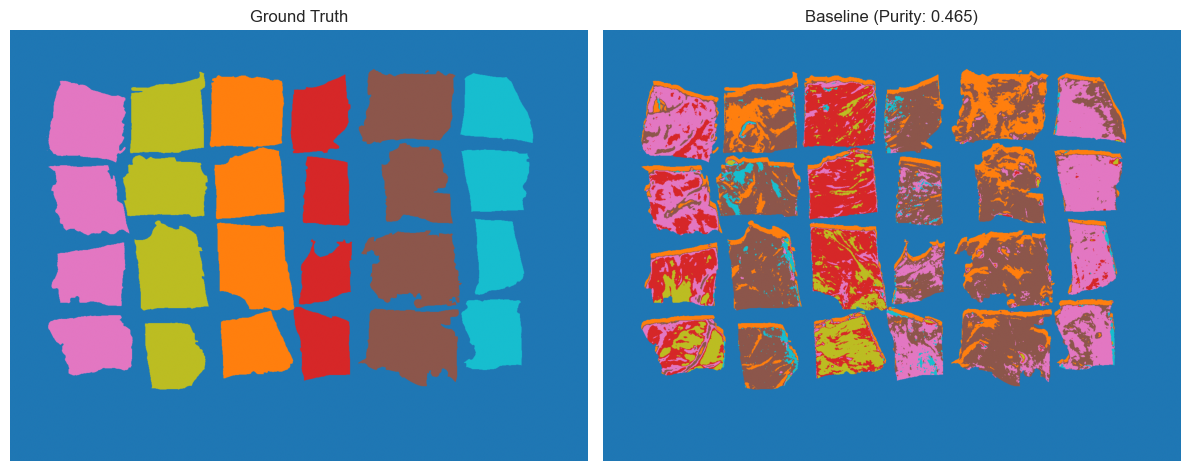

In [7]:
print("="*80)
print("BASELINE: Clustering with Full Data")
print("="*80)

# Run clustering on full data
cluster_map_full, metrics_full, n_features_full = run_clustering_pipeline(
    full_data, 
    n_true_classes
)

# Calculate ground truth metrics
baseline_metrics = calculate_clustering_accuracy(
    cluster_map_full, 
    ground_truth, 
    np.ones_like(ground_truth, dtype=bool)
)

print(f"\n✓ Baseline Results:")
print(f"  Features: {n_features_full}")
print(f"  Purity: {baseline_metrics['purity']:.4f}")
print(f"  ARI: {baseline_metrics['adjusted_rand_score']:.4f}")
print(f"  NMI: {baseline_metrics['normalized_mutual_info']:.4f}")
print(f"  Silhouette: {metrics_full['silhouette_score']:.4f}")

# Save baseline visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(ground_truth, cmap='tab10')
axes[0].set_title('Ground Truth')
axes[0].axis('off')
axes[1].imshow(cluster_map_full, cmap='tab10')
axes[1].set_title(f'Baseline (Purity: {baseline_metrics["purity"]:.3f})')
axes[1].axis('off')
plt.tight_layout()
plt.savefig(visualizations_dir / "baseline.png", dpi=150, bbox_inches='tight')
plt.show()

## 5. Define Wavelength Selection Configurations

Meaningful configurations that explore different strategies:

In [8]:
# Define meaningful configurations
configurations = [
    # Conservative approaches (15 wavelengths)
    {
        'name': 'conservative_activation',
        'dimension_selection_method': 'activation',
        'perturbation_method': 'percentile',
        'perturbation_magnitudes': [10, 20, 30],
        'n_important_dimensions': 10,
        'n_bands_to_select': 15,
        'normalization_method': 'variance'
    },
    {
        'name': 'conservative_variance',
        'dimension_selection_method': 'variance',
        'perturbation_method': 'standard_deviation',
        'perturbation_magnitudes': [15, 30, 45],
        'n_important_dimensions': 10,
        'n_bands_to_select': 15,
        'normalization_method': 'max_per_excitation'
    },
    {
        'name': 'conservative_pca',
        'dimension_selection_method': 'pca',
        'perturbation_method': 'absolute_range',
        'perturbation_magnitudes': [20, 40, 60],
        'n_important_dimensions': 8,
        'n_bands_to_select': 15,
        'normalization_method': 'variance'
    },
    
    # Minimal approaches (10 wavelengths)
    {
        'name': 'minimal_activation',
        'dimension_selection_method': 'activation',
        'perturbation_method': 'percentile',
        'perturbation_magnitudes': [20, 40, 60],
        'n_important_dimensions': 5,
        'n_bands_to_select': 10,
        'normalization_method': 'variance'
    },
    {
        'name': 'minimal_variance',
        'dimension_selection_method': 'variance',
        'perturbation_method': 'standard_deviation',
        'perturbation_magnitudes': [25, 50, 75],
        'n_important_dimensions': 5,
        'n_bands_to_select': 10,
        'normalization_method': 'max_per_excitation'
    },
    {
        'name': 'minimal_pca',
        'dimension_selection_method': 'pca',
        'perturbation_method': 'percentile',
        'perturbation_magnitudes': [30, 50, 70],
        'n_important_dimensions': 5,
        'n_bands_to_select': 10,
        'normalization_method': 'none'
    },
    
    # Aggressive sensitivity approaches
    {
        'name': 'aggressive_high_sensitivity',
        'dimension_selection_method': 'activation',
        'perturbation_method': 'percentile',
        'perturbation_magnitudes': [40, 60, 80],
        'n_important_dimensions': 3,
        'n_bands_to_select': 10,
        'normalization_method': 'variance'
    },
    {
        'name': 'aggressive_std_based',
        'dimension_selection_method': 'variance',
        'perturbation_method': 'standard_deviation',
        'perturbation_magnitudes': [50, 75, 100],
        'n_important_dimensions': 3,
        'n_bands_to_select': 10,
        'normalization_method': 'max_per_excitation'
    },
    
    # Balanced approaches
    {
        'name': 'balanced_activation_12',
        'dimension_selection_method': 'activation',
        'perturbation_method': 'percentile',
        'perturbation_magnitudes': [15, 30, 45],
        'n_important_dimensions': 7,
        'n_bands_to_select': 12,
        'normalization_method': 'variance'
    },
    {
        'name': 'balanced_variance_12',
        'dimension_selection_method': 'variance',
        'perturbation_method': 'standard_deviation',
        'perturbation_magnitudes': [20, 40, 60],
        'n_important_dimensions': 7,
        'n_bands_to_select': 12,
        'normalization_method': 'max_per_excitation'
    },
]

print(f"Defined {len(configurations)} configurations to test:")
for config in configurations:
    print(f"  • {config['name']}: {config['n_bands_to_select']} bands, "
          f"{config['dimension_selection_method']} method")

Defined 10 configurations to test:
  • conservative_activation: 15 bands, activation method
  • conservative_variance: 15 bands, variance method
  • conservative_pca: 15 bands, pca method
  • minimal_activation: 10 bands, activation method
  • minimal_variance: 10 bands, variance method
  • minimal_pca: 10 bands, pca method
  • aggressive_high_sensitivity: 10 bands, activation method
  • aggressive_std_based: 10 bands, variance method
  • balanced_activation_12: 12 bands, activation method
  • balanced_variance_12: 12 bands, variance method


## 6. Run All Configurations

In [9]:
# Initialize results storage
results = []

print("="*80)
print("RUNNING WAVELENGTH SELECTION CONFIGURATIONS")
print("="*80)

for i, config in enumerate(tqdm(configurations, desc="Testing configurations")):
    config_name = config['name']
    print(f"\n[{i+1}/{len(configurations)}] Running: {config_name}")
    
    try:
        # Step 1: Select wavelengths (FIXED function)
        selected_wavelengths, selection_results = select_informative_wavelengths_fixed(
            data_path, 
            mask_path,
            sample_name,
            config,
            verbose=False
        )
        
        print(f"  Selected {len(selected_wavelengths)} wavelengths: {selected_wavelengths[:5]}...")
        
        # Step 2: Extract subset
        subset_data = extract_wavelength_subset(
            full_data,
            selected_wavelengths,
            verbose=True
        )
        
        # Step 3: Run clustering
        cluster_map, metrics, n_features = run_clustering_pipeline(
            subset_data,
            n_true_classes
        )
        
        # Step 4: Validate against ground truth
        gt_metrics = calculate_clustering_accuracy(
            cluster_map,
            ground_truth,
            np.ones_like(ground_truth, dtype=bool)
        )
        
        # Step 5: Save visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(ground_truth, cmap='tab10')
        axes[0].set_title('Ground Truth')
        axes[0].axis('off')
        
        axes[1].imshow(cluster_map_full, cmap='tab10')
        axes[1].set_title(f'Baseline\nPurity: {baseline_metrics["purity"]:.3f}')
        axes[1].axis('off')
        
        axes[2].imshow(cluster_map, cmap='tab10')
        axes[2].set_title(f'{config_name}\nPurity: {gt_metrics["purity"]:.3f}')
        axes[2].axis('off')
        
        plt.suptitle(f'Configuration: {config_name} ({len(selected_wavelengths)} wavelengths)')
        plt.tight_layout()
        plt.savefig(visualizations_dir / f"{config_name}.png", dpi=150, bbox_inches='tight')
        plt.close()
        
        # Store results
        result = {
            'config_name': config_name,
            'dimension_method': config['dimension_selection_method'],
            'perturbation_method': config['perturbation_method'],
            'n_important_dims': config['n_important_dimensions'],
            'n_bands_selected': len(selected_wavelengths),
            'n_features': n_features,
            'data_reduction_pct': (1 - n_features/n_features_full) * 100,
            'selected_wavelengths': str(selected_wavelengths),
            'purity': gt_metrics['purity'],
            'ari': gt_metrics['adjusted_rand_score'],
            'nmi': gt_metrics['normalized_mutual_info'],
            'v_measure': gt_metrics['v_measure'],
            'homogeneity': gt_metrics['homogeneity'],
            'completeness': gt_metrics['completeness'],
            'silhouette': metrics['silhouette_score'],
            'davies_bouldin': metrics['davies_bouldin_score'],
            'calinski_harabasz': metrics['calinski_harabasz_score']
        }
        
        results.append(result)
        
        print(f"  ✓ Purity: {gt_metrics['purity']:.4f} | ARI: {gt_metrics['adjusted_rand_score']:.4f}")
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        results.append({
            'config_name': config_name,
            'error': str(e)
        })

print("\n" + "="*80)
print(f"Completed {len(results)} configurations")

RUNNING WAVELENGTH SELECTION CONFIGURATIONS


Testing configurations:   0%|          | 0/10 [00:00<?, ?it/s]


[1/10] Running: conservative_activation
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 573687/1447680 valid pixels (39.63%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Excitation 400.0 nm: 25 bands
  - Excitat

Testing configurations:  10%|█         | 1/10 [00:34<05:07, 34.17s/it]

  ✓ Purity: 0.4562 | ARI: 0.2348

[2/10] Running: conservative_variance
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 573687/1447680 valid pixels (39.63%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Excitation

Testing configurations:  20%|██        | 2/10 [01:10<04:42, 35.37s/it]

  ✓ Purity: 0.4686 | ARI: 0.2216

[3/10] Running: conservative_pca
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 573687/1447680 valid pixels (39.63%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Excitation 400.

Testing configurations:  30%|███       | 3/10 [01:42<03:56, 33.79s/it]

  ✓ Purity: 0.4645 | ARI: 0.2235

[4/10] Running: minimal_activation
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 573687/1447680 valid pixels (39.63%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Excitation 40

Testing configurations:  40%|████      | 4/10 [02:13<03:16, 32.78s/it]

  ✓ Purity: 0.4516 | ARI: 0.2314

[5/10] Running: minimal_variance
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 573687/1447680 valid pixels (39.63%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Excitation 400.

Testing configurations:  50%|█████     | 5/10 [02:45<02:42, 32.48s/it]

  ✓ Purity: 0.4799 | ARI: 0.2346

[6/10] Running: minimal_pca
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 573687/1447680 valid pixels (39.63%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Excitation 400.0 nm:

Testing configurations:  60%|██████    | 6/10 [03:17<02:09, 32.40s/it]

  ✓ Purity: 0.4805 | ARI: 0.2354

[7/10] Running: aggressive_high_sensitivity
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 573687/1447680 valid pixels (39.63%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Exci

Testing configurations:  70%|███████   | 7/10 [03:49<01:36, 32.07s/it]

  ✓ Purity: 0.4516 | ARI: 0.2314

[8/10] Running: aggressive_std_based
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 573687/1447680 valid pixels (39.63%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Excitation 

Testing configurations:  80%|████████  | 8/10 [04:22<01:04, 32.49s/it]

  ✓ Purity: 0.4799 | ARI: 0.2346

[9/10] Running: balanced_activation_12
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 573687/1447680 valid pixels (39.63%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Excitatio

Testing configurations:  90%|█████████ | 9/10 [04:56<00:32, 32.99s/it]

  ✓ Purity: 0.4562 | ARI: 0.2348

[10/10] Running: balanced_variance_12
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: C:\Users\meloy\PycharmProjects\Capstone\results\Lichens_wavelength_selection\output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 573687/1447680 valid pixels (39.63%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Excitation

Testing configurations: 100%|██████████| 10/10 [05:29<00:00, 32.98s/it]

  ✓ Purity: 0.4813 | ARI: 0.2360

Completed 10 configurations


## 7. Compile and Save Results

In [10]:
# Create DataFrame from results
df_results = pd.DataFrame(results)

# Add baseline row
baseline_row = {
    'config_name': 'BASELINE_FULL_DATA',
    'dimension_method': 'N/A',
    'perturbation_method': 'N/A',
    'n_important_dims': 'N/A',
    'n_bands_selected': total_bands,
    'n_features': n_features_full,
    'data_reduction_pct': 0.0,
    'selected_wavelengths': 'ALL',
    'purity': baseline_metrics['purity'],
    'ari': baseline_metrics['adjusted_rand_score'],
    'nmi': baseline_metrics['normalized_mutual_info'],
    'v_measure': baseline_metrics['v_measure'],
    'homogeneity': baseline_metrics['homogeneity'],
    'completeness': baseline_metrics['completeness'],
    'silhouette': metrics_full['silhouette_score'],
    'davies_bouldin': metrics_full['davies_bouldin_score'],
    'calinski_harabasz': metrics_full['calinski_harabasz_score']
}

df_results = pd.concat([pd.DataFrame([baseline_row]), df_results], ignore_index=True)

# Sort by purity
df_results = df_results.sort_values('purity', ascending=False)

print("Results DataFrame created:")
print(df_results[['config_name', 'n_bands_selected', 'purity', 'ari', 'nmi']].head(10))

Results DataFrame created:
                config_name  n_bands_selected    purity       ari       nmi
10     balanced_variance_12                10  0.481271  0.235959  0.318961
6               minimal_pca                 9  0.480546  0.235418  0.319864
8      aggressive_std_based                 9  0.479936  0.234617  0.318446
5          minimal_variance                 9  0.479936  0.234617  0.318446
2     conservative_variance                13  0.468574  0.221552  0.312119
0        BASELINE_FULL_DATA               192  0.465390  0.218460  0.308661
3          conservative_pca                 9  0.464504  0.223489  0.312300
1   conservative_activation                 8  0.456203  0.234793  0.294624
9    balanced_activation_12                 8  0.456203  0.234793  0.294624
4        minimal_activation                 7  0.451603  0.231358  0.293414


In [11]:
# Save to Excel and CSV
excel_path = results_dir / "wavelength_selection_results.xlsx"
csv_path = results_dir / "wavelength_selection_results.csv"

# Save to Excel with formatting
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    df_results.to_excel(writer, sheet_name='Results', index=False)
    
    # Add summary sheet
    summary = pd.DataFrame({
        'Metric': ['Best Purity', 'Best ARI', 'Best NMI', 'Most Reduction'],
        'Configuration': [
            df_results.loc[df_results['purity'].idxmax(), 'config_name'],
            df_results.loc[df_results['ari'].idxmax(), 'config_name'],
            df_results.loc[df_results['nmi'].idxmax(), 'config_name'],
            df_results.loc[df_results['data_reduction_pct'].idxmax(), 'config_name']
        ],
        'Value': [
            df_results['purity'].max(),
            df_results['ari'].max(),
            df_results['nmi'].max(),
            df_results['data_reduction_pct'].max()
        ]
    })
    summary.to_excel(writer, sheet_name='Summary', index=False)

# Save to CSV
df_results.to_csv(csv_path, index=False)

print(f"\n✓ Results saved to:")
print(f"  Excel: {excel_path}")
print(f"  CSV: {csv_path}")


✓ Results saved to:
  Excel: C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\validation_results\20250908_165719\wavelength_selection_results.xlsx
  CSV: C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\validation_results\20250908_165719\wavelength_selection_results.csv


## 8. Analysis and Visualization

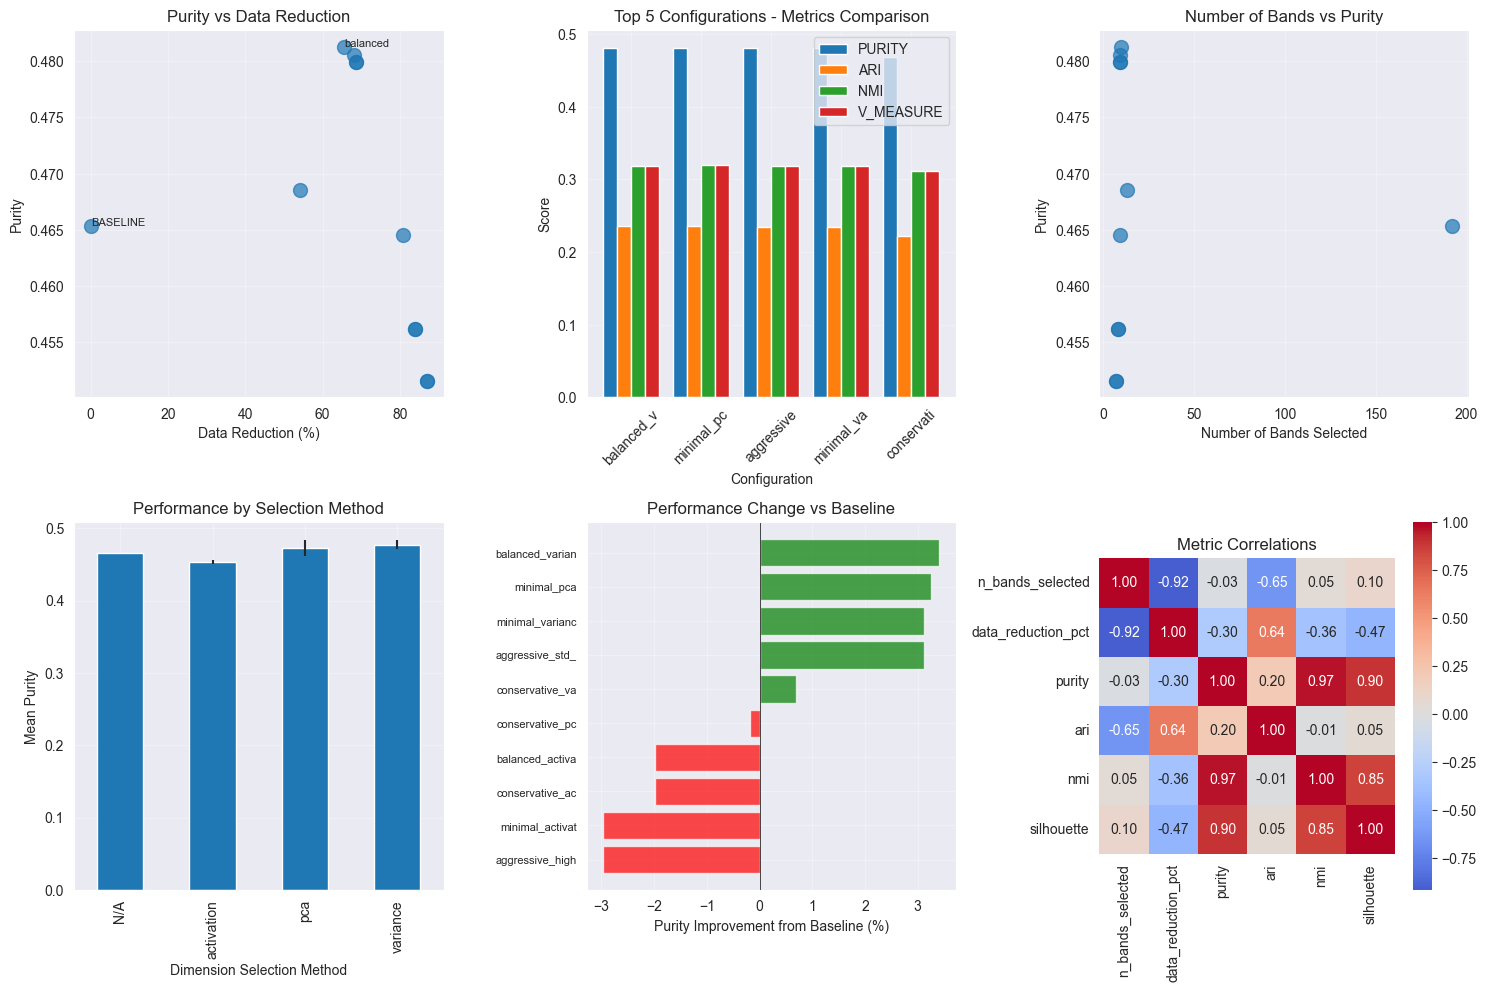

✓ Analysis plots saved


In [12]:
# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: Purity vs Data Reduction
axes[0, 0].scatter(df_results['data_reduction_pct'], df_results['purity'], s=100, alpha=0.7)
axes[0, 0].set_xlabel('Data Reduction (%)')
axes[0, 0].set_ylabel('Purity')
axes[0, 0].set_title('Purity vs Data Reduction')
axes[0, 0].grid(True, alpha=0.3)

# Annotate points
for idx, row in df_results.iterrows():
    if row['config_name'] in ['BASELINE_FULL_DATA', df_results.loc[df_results['purity'].idxmax(), 'config_name']]:
        axes[0, 0].annotate(row['config_name'].split('_')[0], 
                           (row['data_reduction_pct'], row['purity']),
                           fontsize=8)

# Plot 2: Metrics comparison bar plot
metrics_cols = ['purity', 'ari', 'nmi', 'v_measure']
top_5 = df_results.nlargest(5, 'purity')
x = np.arange(len(top_5))
width = 0.2

for i, metric in enumerate(metrics_cols):
    axes[0, 1].bar(x + i*width, top_5[metric], width, label=metric.upper())

axes[0, 1].set_xlabel('Configuration')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Top 5 Configurations - Metrics Comparison')
axes[0, 1].set_xticks(x + width * 1.5)
axes[0, 1].set_xticklabels([c[:10] for c in top_5['config_name']], rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Number of bands vs Purity
axes[0, 2].scatter(df_results['n_bands_selected'], df_results['purity'], s=100, alpha=0.7)
axes[0, 2].set_xlabel('Number of Bands Selected')
axes[0, 2].set_ylabel('Purity')
axes[0, 2].set_title('Number of Bands vs Purity')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Method comparison
method_results = df_results.groupby('dimension_method')['purity'].agg(['mean', 'std'])
method_results.plot(kind='bar', y='mean', yerr='std', ax=axes[1, 0], legend=False)
axes[1, 0].set_xlabel('Dimension Selection Method')
axes[1, 0].set_ylabel('Mean Purity')
axes[1, 0].set_title('Performance by Selection Method')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Purity improvement from baseline
baseline_purity = df_results[df_results['config_name'] == 'BASELINE_FULL_DATA']['purity'].values[0]
df_results['purity_improvement'] = ((df_results['purity'] - baseline_purity) / baseline_purity) * 100

improvement_data = df_results[df_results['config_name'] != 'BASELINE_FULL_DATA'].sort_values('purity_improvement')
colors = ['green' if x >= 0 else 'red' for x in improvement_data['purity_improvement']]

axes[1, 1].barh(range(len(improvement_data)), improvement_data['purity_improvement'], color=colors, alpha=0.7)
axes[1, 1].set_yticks(range(len(improvement_data)))
axes[1, 1].set_yticklabels([c[:15] for c in improvement_data['config_name']], fontsize=8)
axes[1, 1].set_xlabel('Purity Improvement from Baseline (%)')
axes[1, 1].set_title('Performance Change vs Baseline')
axes[1, 1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Correlation matrix
corr_cols = ['n_bands_selected', 'data_reduction_pct', 'purity', 'ari', 'nmi', 'silhouette']
corr_matrix = df_results[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, ax=axes[1, 2])
axes[1, 2].set_title('Metric Correlations')

plt.tight_layout()
plt.savefig(results_dir / "analysis_summary.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Analysis plots saved")

## 9. Final Summary

In [13]:
print("="*80)
print("WAVELENGTH SELECTION VALIDATION - FINAL SUMMARY")
print("="*80)

print("\n📊 BASELINE PERFORMANCE:")
print(f"  Features: {n_features_full}")
print(f"  Purity: {baseline_purity:.4f}")
print(f"  ARI: {baseline_metrics['adjusted_rand_score']:.4f}")
print(f"  NMI: {baseline_metrics['normalized_mutual_info']:.4f}")

print("\n🏆 BEST CONFIGURATIONS:")
print("\n  By Purity:")
best_purity = df_results.loc[df_results['purity'].idxmax()]
print(f"    Config: {best_purity['config_name']}")
print(f"    Bands: {best_purity['n_bands_selected']} ({best_purity['data_reduction_pct']:.1f}% reduction)")
print(f"    Purity: {best_purity['purity']:.4f} ({best_purity['purity_improvement']:.1f}% improvement)")

print("\n  By ARI:")
best_ari = df_results.loc[df_results['ari'].idxmax()]
print(f"    Config: {best_ari['config_name']}")
print(f"    Bands: {best_ari['n_bands_selected']} ({best_ari['data_reduction_pct']:.1f}% reduction)")
print(f"    ARI: {best_ari['ari']:.4f}")

print("\n  Most Efficient (>90% reduction with good performance):")
efficient = df_results[(df_results['data_reduction_pct'] > 90) & 
                       (df_results['purity'] > baseline_purity * 0.95)]
if not efficient.empty:
    best_efficient = efficient.loc[efficient['purity'].idxmax()]
    print(f"    Config: {best_efficient['config_name']}")
    print(f"    Bands: {best_efficient['n_bands_selected']} ({best_efficient['data_reduction_pct']:.1f}% reduction)")
    print(f"    Purity: {best_efficient['purity']:.4f}")
else:
    print("    None found with >90% reduction maintaining 95% of baseline purity")

print("\n💡 KEY INSIGHTS:")
avg_by_method = df_results[df_results['config_name'] != 'BASELINE_FULL_DATA'].groupby('dimension_method')['purity'].mean()
best_method = avg_by_method.idxmax()
print(f"  • Best selection method on average: {best_method} (mean purity: {avg_by_method[best_method]:.4f})")

configs_10_bands = df_results[df_results['n_bands_selected'] == 10]
if not configs_10_bands.empty:
    print(f"  • Best 10-band configuration: {configs_10_bands.loc[configs_10_bands['purity'].idxmax(), 'config_name']}")
    print(f"    Achieves {configs_10_bands['purity'].max():.4f} purity with {configs_10_bands['data_reduction_pct'].max():.1f}% reduction")

configs_15_bands = df_results[df_results['n_bands_selected'] == 15]
if not configs_15_bands.empty:
    print(f"  • Best 15-band configuration: {configs_15_bands.loc[configs_15_bands['purity'].idxmax(), 'config_name']}")
    print(f"    Achieves {configs_15_bands['purity'].max():.4f} purity with {configs_15_bands['data_reduction_pct'].max():.1f}% reduction")

print("\n📁 RESULTS SAVED TO:")
print(f"  Directory: {results_dir}")
print(f"  Excel file: wavelength_selection_results.xlsx")
print(f"  CSV file: wavelength_selection_results.csv")
print(f"  Visualizations: {len(list(visualizations_dir.glob('*.png')))} images saved")

print("\n✅ Pipeline completed successfully!")

WAVELENGTH SELECTION VALIDATION - FINAL SUMMARY

📊 BASELINE PERFORMANCE:
  Features: 192
  Purity: 0.4654
  ARI: 0.2185
  NMI: 0.3087

🏆 BEST CONFIGURATIONS:

  By Purity:
    Config: balanced_variance_12
    Bands: 10 (65.6% reduction)
    Purity: 0.4813 (3.4% improvement)

  By ARI:
    Config: balanced_variance_12
    Bands: 10 (65.6% reduction)
    ARI: 0.2360

  Most Efficient (>90% reduction with good performance):
    None found with >90% reduction maintaining 95% of baseline purity

💡 KEY INSIGHTS:
  • Best selection method on average: variance (mean purity: 0.4774)
  • Best 10-band configuration: balanced_variance_12
    Achieves 0.4813 purity with 65.6% reduction

📁 RESULTS SAVED TO:
  Directory: C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\validation_results\20250908_165719
  Excel file: wavelength_selection_results.xlsx
  CSV file: wavelength_selection_results.csv
  Visualizations: 11 images saved

✅ Pipeline completed successfully!
